# Chapter 7: k-Nearest Neighbors (k-NN)


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.16
>   - pandas: 1.0.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


Make sure DMBA package is available

In [1]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Import required packages for this chapter
from pathlib import Path
import math

import pandas as pd

from sklearn.metrics import pairwise
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor #, NearestNeighbors

import dmba

%matplotlib inline

# Problem 7.2 Personal Loan Acceptance

Universal Bank is a relatively young bank growing rapidly in terms of overall customer acquisition. The majority of these customers are liability customers (depositors) with varying sizes of relationship with the bank. The customer base of asset customers (borrowers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business. In particular, it wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise smarter campaigns with better target marketing. The goal is to use
k-NN to predict whether a new customer will accept a loan offer. This will serve as the basis for the design of a new campaign.

The file _UniversalBank.csv_ contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer’s relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign.

Partition the data into training (60%) and validation (40%) sets.

__7.2.a__ Consider the following customer:

Age = 40, Experience = 10, Income = 84, Family = 2, CCAvg = 2, Education_1= 0, Education_2 = 1, Education_3 = 0, Mortgage = 0, Securities Account = 0, CD Account = 0, Online = 1, and Credit Card = 1. Perform a k-NN classification with all predictors except ID and ZIP code using k = 1. Remember to transform categorical predictors with more than two categories into dummy variables first. Specify the success class as 1 (loan acceptance), and use the default cutoff value of 0.5. How would this customer be classified?

__Answer:__ 

#### Data preparation
Load the data and remove unnecessary columns (ID, ZIP Code). Split the data into training (60%) and validation (40%) sets (use `random_state=1`).

In [96]:
# Load the data
bank_df = dmba.load_data('UniversalBank.csv')

# Drop ID and zip code columns
bank_df = bank_df.drop(columns=['ID', 'ZIP Code'])

# Make sure that the result is as expected
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [97]:
# modify column names
bank_df.columns=bank_df.columns.str.replace(' ','_')
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [111]:
# create dummy variables for categorical variable, we consider Education as categorical variable
bank_dummies=pd.get_dummies(bank_df, columns=['Education'],prefix='Education',drop_first=False)
bank_dummies.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,25,1,49,4,1.6,0,0,1,0,0,0,True,False,False
1,45,19,34,3,1.5,0,0,1,0,0,0,True,False,False
2,39,15,11,1,1.0,0,0,0,0,0,0,True,False,False
3,35,9,100,1,2.7,0,0,0,0,0,0,False,True,False
4,35,8,45,4,1.0,0,0,0,0,0,1,False,True,False


In [99]:
# split dataset into training (60%) and validation (40%) sets
X=bank_dummies.drop(columns=['Personal_Loan'])
y=bank_dummies['Personal_Loan']

train_X,valid_X,train_y,valid_y=train_test_split(X,y,test_size=0.4, random_state=1)

In [100]:
# new customer
newCustomer = pd.DataFrame([{'Age': 40, 'Experience': 10, 'Income': 84, 'Family': 2, 'CCAvg': 2, 'Mortgage': 0,
                             'Securities_Account': 0, 'CD_Account': 0, 'Online': 1, 'CreditCard': 1, 'Education_1': 0, 
                             'Education_2': 1, 'Education_3': 0}],
                            columns=['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage', 'Securities_Account',
                                   'CD_Account', 'Online', 'CreditCard', 'Education_1', 'Education_2', 'Education_3'])
newCustomer

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40,10,84,2,2,0,0,0,1,1,0,1,0


In [101]:
# normalize training and validation sets. The transformation is trained using the training set only.
# if you don't convert the integer columns to real numbers (float64), 
# the StandardScaler will raise a DataConversionWarning. This is expected
from sklearn.preprocessing import StandardScaler
train_X=train_X.astype('float64')
valid_X=valid_X.astype('float64')
scaler=StandardScaler()
X_scaler_train=scaler.fit_transform(train_X)
X_scaler_valid=scaler.fit_transform(valid_X)

In [102]:
# k-NN using k = 1
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_scaler_train,train_y)

KNeighborsClassifier(n_neighbors=1)

In [103]:
# predicted class of the new record
new_customer_standard=scaler.fit_transform(newCustomer)
prediction=knn.predict(new_customer_standard)
print(f'Loan accepted=1, loan rejected=0: {prediction[0]}')

Loan accepted=1, loan rejected=0: 0


In [104]:
# predicted probability
proba=knn.predict_proba(new_customer_standard)
print("Predicted probability of loan acceptance (class = 1):", proba[0][1])


Predicted probability of loan acceptance (class = 1): 0.0


New customer is predicted to not accept a loan offer.

__7.2.b__ What is a choice of k that balances between overfitting and ignoring the predictor information?

__Answer__

In [109]:
# Train a classifier for different values of k
results = []
for k in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_scaler_train, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(X_scaler_valid))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1    0.9545
1    2    0.9520
2    3    0.9555
3    4    0.9490
4    5    0.9550
5    6    0.9505
6    7    0.9520
7    8    0.9460
8    9    0.9480
9   10    0.9440
10  11    0.9470


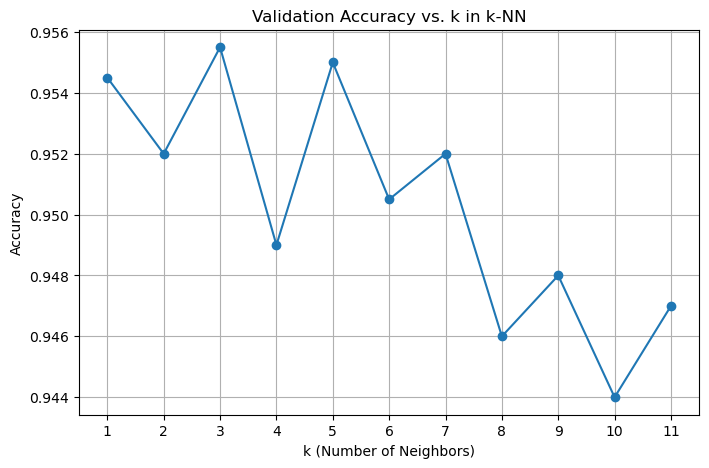

In [110]:
import matplotlib.pyplot as plt
# plot accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(results['k'], results['accuracy'], marker='o')
plt.title('Validation Accuracy vs. k in k-NN')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(results['k'])
plt.show()

We choose the best k, which minimizes the misclassification rate in the validation set. Our best k is `k=3`

__7.2.c.__ Show the confusion matrix for the validation data that results from using the best k.

__Answer__ 

In [114]:
# k-NN model for k = 3
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_scaler_train,train_y)
pred_valid=knn.predict(X_scaler_valid)

# confusion matrix for validation data
matrix=confusion_matrix(valid_y,pred_valid)
print(f'confusion matrix for validation data using k=3:\n{matrix}')

confusion matrix for validation data using k=3:
[[1799    8]
 [  81  112]]


__7.2.d.__ Consider the following customer: Age = 40, Experience = 10, Income = 84, Family = 2, CCAvg = 2, Education_1 = 0, Education_2 = 1, Education_3 = 0, Mortgage = 0, Securities Account = 0, CD Account = 0, Online = 1 and Credit Card = 1. Classify the customer using the best k.

__Answer__

In [115]:
# predicted class
ncustomer_standard=scaler.fit_transform(newCustomer)
prediction=knn.predict(ncustomer_standard)
print(f'Loan accepted=1, loan rejected=0: {prediction[0]}')

Loan accepted=1, loan rejected=0: 0


In [117]:
# predicted probability
probability=knn.predict_proba(ncustomer_standard)
print("Predicted probability of loan acceptance:", probability[0][1])

Predicted probability of loan acceptance: 0.0


__7.2.e.__ Repartition the data, this time into training, validation, and test sets (50% : 30% : 20%). Apply the k-NN method with the k chosen above. Compare the confusion matrix of the test set with that of the training and validation sets. Comment on the differences and their reason.

__Answer__ 

In [119]:
# partition the data into training (50%), validation (30%) and test (20%) sets
# Separate features and target
X = bank_dummies.drop(columns=['Personal_Loan'])
y = bank_dummies['Personal_Loan']

# Split into 50% train, 30% validation, 20% test
# Split into Train (50%), Temp (50%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=1)

# Split Temp into Validation (30%) and Test (20%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=1)  # 0.4 * 0.5 = 20%


In [120]:
# normalize training and validation sets. The transformation is trained using the training set only.
# if you don't convert the integer columns to real numbers (float64), 
# the StandardScaler will raise a DataConversionWarning. This is expected

# Convert to float64 for StandardScaler
X_train = X_train.astype('float64')
X_valid = X_valid.astype('float64')
X_test = X_test.astype('float64')

# Normalize fit on train only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [122]:
# k-NN model for best k = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

#Predictions
y_train_pred = knn.predict(X_train_scaled)
y_valid_pred = knn.predict(X_valid_scaled)
y_test_pred = knn.predict(X_test_scaled)

# Confusion Matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_valid = confusion_matrix(y_valid, y_valid_pred)
cm_test = confusion_matrix(y_test, y_test_pred)



In [129]:
# confusion matrix of training set
print(f'confusion matrix for training set:\n{cm_train}')
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

confusion matrix for training set:
[[2258    1]
 [  60  181]]
Train Accuracy: 0.9756


In [130]:
# confusion matrix of validation set
print(f'confusion matrix for validation set:\n{cm_valid}')
print("Validation Accuracy:", accuracy_score(y_valid, y_valid_pred))

confusion matrix for validation set:
[[1343    6]
 [  62   89]]
Validation Accuracy: 0.9546666666666667


In [131]:
# confusion matrix of test set
print(f'confusion matrix for test set:\n{cm_test}')
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

confusion matrix for test set:
[[905   7]
 [ 35  53]]
Test Accuracy: 0.958
